In [ ]:
# default_exp timeseries.learner

# timeseries.learner

> API details.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.basics import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.model import *
from fastrenewables.timeseries.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *
from fastrenewables.losses import VILoss
from fastrenewables.utils import *
import pandas as pd

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
#hide
def _tensor_to_device(x, device):
    if isinstance(x, torch.Tensor):
        x = x.to(device)
    return x    

In [ ]:
#export
def fast_prediction_ts(model, to, flatten, filter, device="cpu"):
    # to increase speed we direclty predict on all tensors   
    if isinstance(to, (TimeseriesDataset)):
        with torch.no_grad():
            cats, conts = _tensor_to_device(to.cats, device), _tensor_to_device(to.conts, device)

            preds = model(cats, conts)

        preds, targets = to_np(preds), to_np(to.ys)

        if flatten:
            preds, targets = preds.reshape(-1), targets.reshape(-1)

        if filter:
            targets, preds = filter_preds(targets, preds)
    else:
        raise NotImplementedError("Unknown type")
        
        
    return preds, targets


In [ ]:
#export
class RenewableTimeseriesLearner(Learner):
    "`Learner` for renewable timerseries data."
    def predict(self, ds_idx=1, test_dl=None, filter=True, as_df=False, flatten=True):
        device = next(self.model.parameters()).device
        preds, targets = None, None
        if test_dl is not None:
            to = test_dl.train_ds
        elif ds_idx == 0:
            to = self.dls.train_ds
        elif ds_idx == 1:
            to = self.dls.valid_ds
        
        preds, targets = fast_prediction_ts(self.model, to, flatten=flatten, filter=filter)
        
        if as_df:
            return pd.DataFrame({"Prediction": preds, "Target":targets}, index=to.indexes.reshape(-1))
        else:
            return preds, targets

In [ ]:
show_doc(RenewableTimeseriesLearner, title_level=3)

<h3 id="RenewableTimeseriesLearner" class="doc_header"><code>class</code> <code>RenewableTimeseriesLearner</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>RenewableTimeseriesLearner</code>(**`dls`**, **`model`**, **`loss_func`**=*`None`*, **`opt_func`**=*`Adam`*, **`lr`**=*`0.001`*, **`splitter`**=*`trainable_params`*, **`cbs`**=*`None`*, **`metrics`**=*`None`*, **`path`**=*`None`*, **`model_dir`**=*`'models'`*, **`wd`**=*`None`*, **`wd_bn_bias`**=*`False`*, **`train_bn`**=*`True`*, **`moms`**=*`(0.95, 0.85, 0.95)`*) :: `Learner`

`Learner` for renewable timerseries data.

In [ ]:
def get_dls(cat_names = ["TaskID", 'Month', 'Day', 'Hour'], cont_names=None, y_names="PowerGeneration", y_block=RegressionBlock(), post_hooks=[]):
    

    if cont_names is None:
        cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
           'ASWDIRS_SFC_0_M', 'WindSpeed58m']
    
    pd.options.mode.chained_assignment=None
    kwargs = {"post_hooks": post_hooks}
    dls = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5"), 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[FilterYear(year=2020), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=Categorify, 
                                                bs=12,
                                                y_block=y_block,
                                                post_hooks=post_hooks)
    return dls



In [ ]:
dls = get_dls(y_names="PowerGeneration", y_block=RegressionBlock())

We have one ouput for the regression task, the PowerGeneration and the MSE loss as default loss. Note that these values are inherited by the `TabularPandas` module from `fastai`.

In [ ]:
f"Number of targets: {dls.train_ds.c} with loss {dls.train_ds.loss_func}."

'Number of targets: 1 with loss FlattenedLoss of MSELoss().'

Therefore, we can easily extend this to multiple targets by providing the required y columns.

In [ ]:
dls = get_dls(cont_names = "WindSpeed58m", y_names=['T_HAG_2_M', 'RELHUM_HAG_2_M'], y_block=RegressionBlock())
f"Number of targets: {dls.train_ds.c}."

'Number of targets: 2.'

We can also use the same procedure for classification.

In [ ]:
dls = get_dls(y_names=["TaskID"], y_block=CategoryBlock())
f"Number of targets: {dls.train_ds.c} with loss {dls.train_ds.loss_func}."

'Number of targets: 3 with loss FlattenedLoss of CrossEntropyLoss().'

However, with the default values, we have one value for each timestamp. But in most cases we only want to classify a single sample for a timeseries sample.

In [ ]:
y = dls.one_batch()[-1]
y

tensor([[[ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2]],

        [[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
           1,  1,  1,  1,  1,  1,  1]],

        [[ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2]],

        [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1]],

        [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1]],

        [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1]],

        [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1]],

        [[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
           1,  1,  1,  1,  1,  1,  1]],

        [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1

To overcome this issue, we can apply `post_hooks` to shorten the target timeseries. 

In [ ]:
dls = get_dls(y_names=["TaskID"], y_block=CategoryBlock(), post_hooks=[reduce_target_timeseries_to_element])
f"Number of targets: {dls.train_ds.c} with loss {dls.train_ds.loss_func}."
y = dls.one_batch()[-1]
y

tensor([[[ 2]],

        [[-1]],

        [[ 1]],

        [[-1]],

        [[-1]],

        [[-1]],

        [[-1]],

        [[-1]],

        [[-1]],

        [[-1]],

        [[ 1]],

        [[ 1]]])

In [ ]:
#export
@delegates(Learner.__init__)
def renewable_timeseries_learner(dls, layers=None, emb_szs=None, config=None, 
                                 n_out=None, y_range=None, 
                                 embedding_type=EmbeddingType.Normal, 
                                 input_sequence_length=None,
                                 output_sequence_length=None,
                                 sequence_transform=None,
                                 **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    
    if n_out is None: 
        n_out = get_c(dls)
#     n_out = dls.train_ds.ys.shape[1]
        
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    
    if layers is None: layers = [len(dls.cont_names), 200, 100, n_out]
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
        
    embed_p = kwargs["embed_p"].pop() if "embed_p" in kwargs.keys() else 0.1
    
    emb_module = None
    if len(dls.train_ds.cat_names) > 0:
        emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
        emb_module = EmbeddingModule(None, embedding_dropout=embed_p, embedding_dimensions=emb_szs)
        
    model = TemporalCNN(layers, embedding_module=emb_module, 
                        input_sequence_length=input_sequence_length,
                        output_sequence_length=output_sequence_length, 
                        sequence_transform=sequence_transform,
                        **config)
    
    if embedding_type==EmbeddingType.Bayes and "loss_func" not in kwargs.keys():
        base_loss = getattr(dls.train_ds, 'loss_func', None)
        assert base_loss is not None, "Could not infer loss function from the data, please pass a loss function."
        loss_func=VILoss(model=model, base_loss=base_loss, kl_weight=0.1)
        kwargs["loss_func"] = loss_func
    
    return RenewableTimeseriesLearner(dls, model, **kwargs)

In [ ]:
show_doc(renewable_timeseries_learner)

<h4 id="renewable_timeseries_learner" class="doc_header"><code>renewable_timeseries_learner</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>renewable_timeseries_learner</code>(**`dls`**, **`layers`**=*`None`*, **`emb_szs`**=*`None`*, **`config`**=*`None`*, **`n_out`**=*`None`*, **`y_range`**=*`None`*, **`embedding_type`**=*`<EmbeddingType.Normal: 0>`*, **`input_sequence_length`**=*`None`*, **`output_sequence_length`**=*`None`*, **`sequence_transform`**=*`None`*, **`loss_func`**=*`None`*, **`opt_func`**=*`Adam`*, **`lr`**=*`0.001`*, **`splitter`**=*`trainable_params`*, **`cbs`**=*`None`*, **`metrics`**=*`None`*, **`path`**=*`None`*, **`model_dir`**=*`'models'`*, **`wd`**=*`None`*, **`wd_bn_bias`**=*`False`*, **`train_bn`**=*`True`*, **`moms`**=*`(0.95, 0.85, 0.95)`*)

Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params.

In [ ]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.basics import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastrenewables.losses import VILoss

In [ ]:
dls = get_dls(y_names="PowerGeneration", y_block=RegressionBlock())

In [ ]:
learner = renewable_timeseries_learner(dls, metrics=rmse)

In [ ]:
learner.loss_func

FlattenedLoss of MSELoss()

In [ ]:
cats, conts, ys = dls.one_batch()

In [ ]:
learner.model

TemporalCNN(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(4, 3)
      (1): Embedding(13, 7)
      (2): Embedding(32, 11)
      (3): Embedding(25, 10)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): TemporalConvNet(
    (temporal_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(6, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (act_func1): ReLU()
        (dropout1): Dropout2d(p=0.0, inplace=False)
        (conv2): Conv1d(200, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (act_func2): ReLU()
        (dropout2): Dropout2d(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(6, 200, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout2d(p=0.0, inplace=False)

In [ ]:
cats.shape

torch.Size([12, 4, 24])

In [ ]:
learner.model(cats, conts).shape

torch.Size([12, 1, 24])

In [ ]:
ys.shape

torch.Size([12, 1, 24])

In [ ]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,_rmse,time
0,0.043034,0.022965,0.151543,00:01
1,0.026070,0.020878,0.144491,00:01
2,0.020154,0.016968,0.130263,00:01
3,0.016189,0.016060,0.126727,00:01
4,0.014489,0.015892,0.126065,00:01


In [ ]:
preds, targets = learner.predict(0)

In [ ]:
result_df = learner.predict(0, as_df=True)

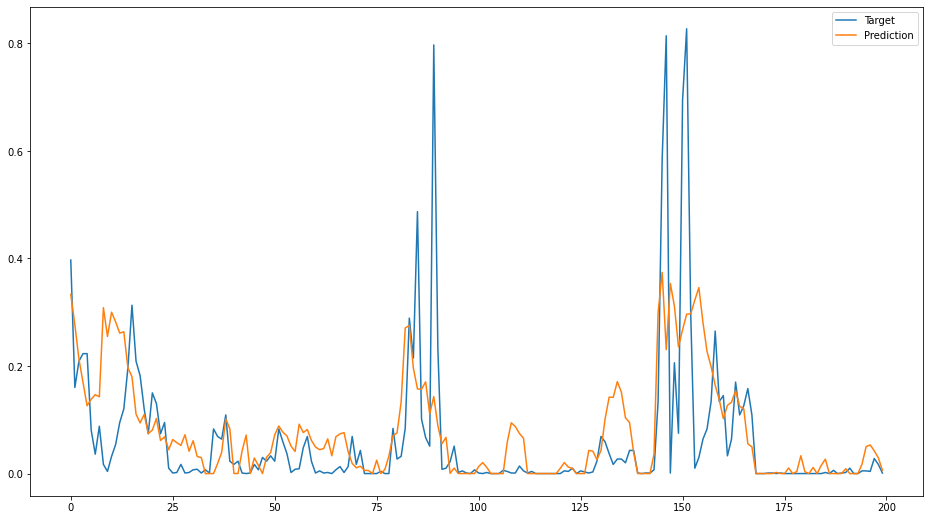

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(targets[0:200], label="Target")
plt.plot(preds[0:200], label="Prediction")
plt.legend()
# result_df[500:1000].plot(figsize=(16,9))

Create a clasification dataloader, where we aim to forecast the task ID.

In [ ]:
dls = get_dls(cat_names = ['Month', 'Day', 'Hour'], y_names=["TaskID"], 
              y_block=CategoryBlock(), 
              post_hooks=[reduce_target_timeseries_to_element])
f"Number of classes {dls.c}"

'Number of classes 3'

We can either let the `renewable_timeseries_learner` handle the correct output shape by providing the `input_sequence_length` and `output_sequence_length`.

In [ ]:
input_sequence_length=dls.input_sequence_length
output_sequence_length=dls.output_sequence_length
input_sequence_length, output_sequence_length

(24, 1)

In [ ]:
learner = renewable_timeseries_learner(dls, metrics=accuracy, 
               input_sequence_length=input_sequence_length,
               output_sequence_length=output_sequence_length)
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.760260,0.468576,0.774510,00:01
1,0.510835,0.432099,0.799020,00:01
2,0.399204,0.345746,0.838235,00:01
3,0.355183,0.242341,0.906863,00:01
4,0.319330,0.222052,0.916667,00:01


Or alternatively, we can provide a custom layer converts the results of the `CNN` into the required shape for classification.

In [ ]:
num_outputs_last_cnn_layer = 10
sequence_transform=MultiLayerPerceptron([input_sequence_length*num_outputs_last_cnn_layer, dls.c])

In [ ]:
learner = renewable_timeseries_learner(dls, n_out=10, metrics=accuracy, 
               input_sequence_length=input_sequence_length,
               sequence_transform=sequence_transform)

In [ ]:
learner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learner.model

TemporalCNN(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(13, 7)
      (1): Embedding(32, 11)
      (2): Embedding(25, 10)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): TemporalConvNet(
    (temporal_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(6, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (act_func1): ReLU()
        (dropout1): Dropout2d(p=0.0, inplace=False)
        (conv2): Conv1d(200, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (act_func2): ReLU()
        (dropout2): Dropout2d(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(6, 200, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout2d(p=0.0, inplace=False)
          (4): Conv1d(200,

In [ ]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.631588,0.550390,0.725490,00:01
1,0.413493,0.287193,0.897059,00:01
2,0.328369,0.246277,0.911765,00:01
3,0.289502,0.215301,0.921569,00:01
4,0.246048,0.214277,0.921569,00:01


In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00a_utils.ipynb.
Converted 00b_losses.ipynb.
Converted 00c_utils_blitz.ipynb.
Converted 00d_baselines.ipynb.
Converted 00e_metrics.ipynb.
Converted 00f_utils_pytorch.ipynb.
Converted 01_tabular.core.ipynb.
Converted 02_tabular.data.ipynb.
Converted 03_tabular.model.ipynb.
Converted 04_tabular.learner.ipynb.
Converted 05_timeseries.core.ipynb.
Converted 06_timeseries.data.ipynb.
Converted 07_timeseries.model.ipynb.
Converted 08_timeseries.learner.ipynb.
Converted 09_gan.core.ipynb.
Converted 10_autoencoder_models.ipynb.
Converted 11_probabilistic_models.ipynb.
Converted index.ipynb.
